# Half Moons Example
This notebook demonstrates the use of Shadow for the canonical semi-supervised learning example: half moons. 

A strictly supervised (only labeled data) baseline model is trained alongside the same model architecture trained using Exponential Averaging Adversarial Training (EAAT). 

In [1]:
import shadow.utils
shadow.utils.set_seed(0, cudnn_deterministic=True)  # set seeds for reproducibility

### Create Data
Half moons data is generated using the scikit-learn toy datasets interface.

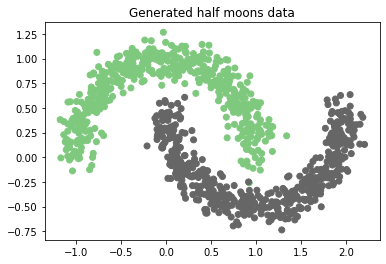

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn import datasets

n_samples = 1000  # number of samples to generate
noise = 0.1  # noise to add to sample locations
x, y = datasets.make_moons(n_samples=n_samples, noise=noise)

plt.scatter(*x.T, c=y, cmap=plt.cm.Accent)
plt.title("Generated half moons data");

### Drop Labels
Since the half moons dataset is synthetic, all labels are available. To test out the semi-supervised learning infrastructure, we artificially remove 99% of labels. To demarcate "unlabeled" samples, we set their corresponding label to `-1`. This is convenient method to handle missing classification labels in torch, as we will see later in the definition of the cross entropy loss.

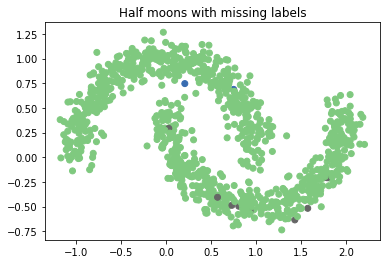

In [3]:
import copy
import numpy as np

unlabeled_frac = 0.99  # fraction of data to drop labels

y_ssml = y.copy()
unlabeled = np.random.choice(range(n_samples), size=int(unlabeled_frac * n_samples), replace=False)
y_ssml[unlabeled] = -1  # set missing labels to -1

plt.scatter(*x.T, c=y_ssml, cmap=plt.cm.Accent)
plt.title("Half moons with missing labels");

## Train a classifier
Next, we will instantiate the various training objects used in torch: models, optimizers, and criterion.

### Model Architecture
We define our simple model architecture for use on this toy problem. We wrap this model into a factory, so that we can produce it twice: once for the baseline and once for the semi-supervised test.

In [4]:
import torch

def model_factory():
    return torch.nn.Sequential(
        torch.nn.Linear(2, 10),
        torch.nn.ReLU(),
        torch.nn.Linear(10, 10),
        torch.nn.ReLU(),
        torch.nn.Linear(10, 2)
    )

device = torch.device('cpu')  # run on cpu, since model and data are very small

### Baseline Model
The baseline model and optimizer are defined normally.

In [5]:
bl = model_factory().to(device)
bl_opt = torch.optim.SGD(bl.parameters(), lr=0.1, momentum=0.9)

### Semi-supervised Model
The semi-supervised model is instantiated with one critical difference: the model is wrapped by the shadow-provided ssml technique (in this case Exponential Averaging Adversarial Training). The wrapper defines additional technique-specific hyperparameters, but should be instead of using a plain model directly.

In [6]:
import shadow.eaat
eaat = shadow.eaat.EAAT(model=model_factory(), alpha=0.8, xi=1e-4, eps=0.3).to(device)
eaat_opt = torch.optim.SGD(eaat.parameters(), lr=0.1, momentum=0.9)

### Loss function
As was alluded to earlier, using `-1` to indicate missing labels is convenient in torch. That is because our standard CrossEntropyLoss criterion already has a parameter to ignore specific label values. We simple instatiate the loss function as normal, but set that parameter (`ignore_index`) to our unlabeled value.

Other loss functions may provide such a functionality or may need to be manually modified so as to mask data with missing labels.

In [7]:
xEnt = torch.nn.CrossEntropyLoss(ignore_index=-1).to(device)

### Training Loop
We train both the baseline and semi-supervised models at the same time using standard `torch` conventions. Since the half-moons dataset is a small toy example, we use the whole dataset at once instead of batching. 

The only modification to the training loop needed for the semi-supervised model is that the loss function is composed of both the supervised loss (`xEnt`) as well as a technique provided unsupervised loss (`eaat.get_technique_cost`). The details of this unsupervised loss vary between  techniques, but it provides the mechanism for semi-supervised learning.

In [8]:
n_epochs = 500
xt, yt = torch.Tensor(x).to(device), torch.LongTensor(y_ssml).to(device)
for epoch in range(n_epochs):
    # Standard forward/backward pass for training baseline
    out = bl(xt)
    loss = xEnt(out, yt)  # ignores the unlabeled data (-1) 
    bl_opt.zero_grad()
    loss.backward()
    bl_opt.step()
    
    # Forward/backward pass for training semi-supervised model
    out = eaat(xt)
    loss = xEnt(out, yt) + eaat.get_technique_cost(xt)  # supervised + unsupervised loss
    eaat_opt.zero_grad()
    loss.backward()
    eaat_opt.step()

## Evaluate performance
Finally, we evaluate and compare performance between our strictly supervised baseline model, and the same model trained using semi-supervised learning.

It is critical to set the EAAT wrapped model into `eval` mode after training, so as to disable certain augmentations performed for semi-supervised learning.

In [9]:
bl.eval()
eaat.eval();

The accuracy provided by SSML greatly outperforms that of the baseline, as we would expect.

In [10]:
import shadow.losses

bl_pred = torch.max(bl(xt), 1)[-1]
eaat_pred = torch.max(eaat(xt), 1)[-1]

print("bl accuracy:", shadow.losses.accuracy(bl_pred, torch.LongTensor(y)).data)
print("eaat accuracy", shadow.losses.accuracy(eaat_pred, torch.LongTensor(y)).data)

bl accuracy: tensor(75.9000, dtype=torch.float64)
eaat accuracy tensor(98.7000, dtype=torch.float64)


### Visualize Decision Boundary
In order to get a better sense of how "good" our EAAT trained model is, we can leverage the fact that half-moons is a toy 2D dataset to visualize the model decision boundary. We define a 2D meshgrid over the data space and evaluate the models over the grid. We then plot the contour corresponding to a score of `0.5`, which represents the decision boundary.

As illustrated in the plot, the baseline learns exactly what it can from the labeled data. However the semi-supervised trained model learns both labeled and unlabeled data and captures the overall data trends despite having labels for only 1% of the training data.

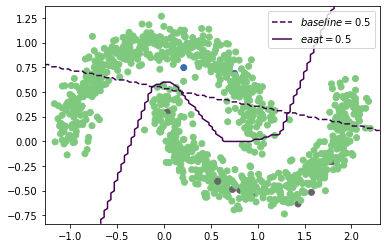

In [11]:
# Determine grid range 
x0_min, x0_max = x[:, 0].min() - 0.1, x[:, 0].max() + 0.1
x1_min, x1_max = x[:, 1].min() - 0.1, x[:, 1].max() + 0.1

# Create grid
x0, x1 = np.meshgrid(np.linspace(x0_min, x0_max, 100),
                     np.linspace(x1_min, x1_max, 100))
grid = torch.FloatTensor(np.hstack((x0.reshape(-1, 1), x1.reshape(-1, 1))))

# Plot the data
plt.scatter(*x.T, c=y_ssml, cmap=plt.cm.Accent)

# Evaluate baseline on the grid and plot decision boundary
bl_pred = torch.max(bl(grid), 1)[-1].numpy().reshape(x0.shape)
cs = plt.contour(x0, x1, bl_pred, levels=[0.5], linestyles='--')
h1, l1 = cs.legend_elements("baseline")

# Evaluate EAAT on the grid and plot decision boundary
eaat_pred = torch.max(eaat(grid), 1)[-1].numpy().reshape(x0.shape)
cs = plt.contour(x0, x1, eaat_pred, levels=[0.5])
h2, l2 = cs.legend_elements("eaat")

plt.legend(h1 + h2, l1 + l2)